## Observational social learning task with a basic working-memory-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo

### Task is defined by the Environment node

In [7]:
class Environment():
    def __init__(self, prob_A, time_sample=2, dt=0.001, seed_env=5):
        self.rng = np.random.RandomState(seed=seed_env)
        self.prob_A = prob_A
        self.prob_B = 1 - prob_A
        self.time_sample = time_sample
        self.dt = dt
        self.obs = 0
        self.weight = 0
        self.inhibit = 0
    def sample(self, t):
        if t % self.time_sample < self.dt:
            self.obs = 1 if self.rng.uniform(0,1) < self.prob_A else -1
            self.n_sample = int(t / self.time_sample)
            # self.weight = 1 - (self.n_sample)/6
            self.weight = 1 / (self.n_sample + 1)
        if t % self.time_sample > self.time_sample/2:
            self.inhibit1 = 0
            self.inhibit2 = 1
        else:
            self.inhibit1 = 1
            self.inhibit2 = 0
        return [self.obs, self.weight, self.inhibit1, self.inhibit2]

### Define the neural network

In [11]:
def build_network(env, n_neurons=500, seed_net=0, syn_feedback=0.1):
    net = nengo.Network(seed=seed_net)
    func_obs = lambda t: env.sample(t)[0]
    func_weight = lambda t: env.sample(t)[1]
    func_inh1 = lambda t: env.sample(t)[2]
    func_inh2 = lambda t: env.sample(t)[3]
    func_load = lambda x: (x[0] - x[1]) * x[2]
    func_diff = lambda x: (x[0] - x[1])
    func_choice = lambda x: -1 if x[0] < 0 else 1
    func_confidence = lambda x: np.abs(x[0])

    with net:
        # external inputs
        net.input_obs = nengo.Node(func_obs)
        net.input_weight = nengo.Node(func_weight)
        net.inhibit1 = nengo.Node(func_inh1)
        net.inhibit2 = nengo.Node(func_inh2)
        # ensembles
        net.obs = nengo.Ensemble(n_neurons, 1)
        net.weight = nengo.Ensemble(n_neurons, 1)
        net.combined = nengo.Ensemble(3*n_neurons, 3, radius=3)
        net.memory = nengo.Ensemble(n_neurons, 1)
        net.temp = nengo.Ensemble(n_neurons, 2)
        net.old = nengo.Ensemble(n_neurons, 1)
        net.decision = nengo.Ensemble(2*n_neurons, 2, radius=1.4)
        # connections
        nengo.Connection(net.input_obs, net.obs)
        nengo.Connection(net.input_weight, net.weight)
        nengo.Connection(net.obs, net.combined[0])
        nengo.Connection(net.old, net.combined[1])
        nengo.Connection(net.weight, net.combined[2])
        nengo.Connection(net.combined, net.memory, function=func_load, transform=syn_feedback)
        nengo.Connection(net.memory, net.memory, synapse=syn_feedback)
        nengo.Connection(net.memory, net.temp[0])
        nengo.Connection(net.old, net.temp[1])
        nengo.Connection(net.temp, net.old, function=func_diff)
        nengo.Connection(net.old, net.old, synapse=syn_feedback)
        nengo.Connection(net.inhibit1, net.temp.neurons, transform=-1e3*np.ones((net.temp.n_neurons, 1)))
        nengo.Connection(net.inhibit2, net.combined.neurons, transform=-1e3*np.ones((net.combined.n_neurons, 1)))
        nengo.Connection(net.memory, net.decision[0], function=func_choice)
        nengo.Connection(net.memory, net.decision[1], function=func_confidence)
        # probes
        net.probe_input = nengo.Probe(net.input_obs, synapse=0.01)
        net.probe_obs = nengo.Probe(net.obs, synapse=0.01)
        net.probe_weight = nengo.Probe(net.weight, synapse=0.01)
        net.probe_memory = nengo.Probe(net.memory, synapse=0.01)
        net.probe_old = nengo.Probe(net.old, synapse=0.01)
        net.probe_decision = nengo.Probe(net.decision, synapse=0.01)
    return net

### Simulate the network for one observation

In [12]:
def simulate(time_sim, seed_sim=0):
    env = Environment(prob_A=0.8)
    net = build_network(env)
    sim = nengo.Simulator(net, seed=seed_sim)
    with sim:
        sim.run(time_sim)
    return net, sim

## Experiment 1

In [13]:
net, sim = simulate(time_sim=12)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

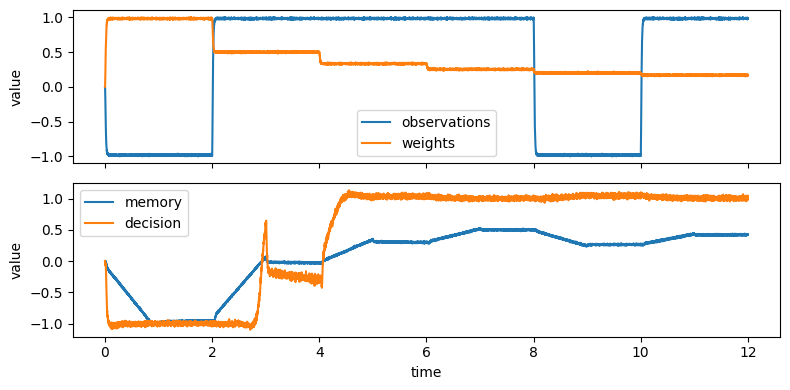

In [16]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
weights = sim.data[net.probe_weight].flatten()
mem = sim.data[net.probe_memory].flatten()
old = sim.data[net.probe_old].flatten()
decision = sim.data[net.probe_decision][:,0].flatten()
confidence = sim.data[net.probe_decision][:,1].flatten()


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
# sns.lineplot(x=times, y=input_obs, ax=ax, label='true observations', color='k')
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=weights, ax=axes[0], label='weights')
sns.lineplot(x=times, y=mem, ax=axes[1], label='memory')
# sns.lineplot(x=times, y=old, ax=ax, label='old')
sns.lineplot(x=times, y=decision, ax=axes[1], label='decision')
# sns.lineplot(x=times, y=confidence, ax=axes[1], label='confidence')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value')
plt.tight_layout()